## BERT classifier v9: Removing toxic words from training data to see which model picks up on context/semantics
Trained on balanced data for male annotators in toxic/nontoxic classes with all toxic words removed from training data, label = toxicity, tested toxicity predictions for toxic comments annotated by men/women.

Using BERT code from: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

Adapted BERT for sentiment analysis using code from: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

After training the model will be saved in bert_male_notoxic_state.bin and can be reused for future runs

Using offensive words list from: https://www.cs.cmu.edu/~biglou/resources/

### Before running, check values of:
* file paths
* MAX_LEN
* batch_size
* size
* epochs
* pretrained
* saved_test_set

In [ ]:
# Install required libraries
#!conda install -y tensorflow
#!conda install -y pytorch torchvision -c pytorch
#!pip install transformers
#!pip install transformers==3.5.1
#!pip install -U seaborn
#!pip install wordcloud

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import random
import math
import nltk
import datetime
import time
import string
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import logging
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pickle
from wordcloud import WordCloud

# In order to use notebook in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Choose whether to use pretrained model
pretrained = True

In [4]:
# Read files and create dataframe (may need to change path)
toxicity_comments = pd.read_csv('../toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
toxicity_annotations = pd.read_csv('../toxicity_annotations.tsv',  sep = '\t')
toxicity_demographics = pd.read_csv('../toxicity_worker_demographics.tsv', sep = '\t')
    
# Take a look at data
display (toxicity_comments.head(5))
display (toxicity_annotations.head(5))
display (toxicity_demographics.head(5))

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
8953.0,Elected or Electoral? JHK,2002,False,article,random,test
26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


,worker_id,gender,english_first_language,age_group,education
0,85,female,0,18-30,bachelors
1,1617,female,0,45-60,bachelors
2,1394,female,0,NaN,bachelors
3,311,male,0,30-45,bachelors
4,1980,male,0,45-60,masters


In [5]:
# Merge into single DataFrame
toxicity = toxicity_comments.merge(toxicity_annotations, how ='outer', on="rev_id")
toxicity = toxicity.merge(toxicity_demographics, how ='outer', on="worker_id").sort_values(by=['rev_id','worker_id'])

# Remove newline and tab tokens from comments
toxicity['comment'] = toxicity['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxicity['comment'] = toxicity['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# Remove annotators with 'other' as gender (too few to include in results)
toxicity = toxicity[toxicity['gender']!='other']

# Add binary gender columns
toxicity = pd.concat([toxicity, pd.get_dummies(toxicity.gender).rename(columns = "{}_binary".format)], axis = 1)

# Look at data with new columns
display (toxicity.head(5))

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education,female_binary,male_binary
3467,2232.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,405,0,1.0,male,0.0,30-45,masters,0,1
3039,2232.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,680,0,0.0,male,0.0,18-30,masters,0,1
0,2232.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,723,0,0.0,female,0.0,30-45,bachelors,1,0
2600,2232.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,772,0,1.0,male,0.0,18-30,bachelors,0,1
2169,2232.0,This: :One can make an analogy in mathematical...,2002,True,article,random,train,1508,0,1.0,female,1.0,45-60,hs,1,0


In [6]:
# Separate comments into categories
very_toxic = toxicity[toxicity.toxicity_score == -2.0]
toxic = toxicity[toxicity.toxicity_score == -1.0]
nontoxic = toxicity[toxicity.toxicity == 0]

# Filter for male annotated data
male_toxic = toxic[toxic.male_binary == 1]
male_very_toxic = very_toxic[very_toxic.male_binary == 1]
male_nontoxic = nontoxic[nontoxic.male_binary == 1]

# Find smallest toxic dataset
size = min(male_toxic.shape[0],male_very_toxic.shape[0])
print("smallest:",size)

# Manually choose size if necessary
# size = 2000

# Split into train and test sets
test_size = math.floor(size*0.2)
train_size = math.ceil(size*0.8)

# Create toxic test dataset and drop from dataframes so not also chosen for training
male_toxic_test = male_toxic.sample(n=test_size)
male_toxic = male_toxic.drop(male_toxic_test.index)
male_vtoxic_test = male_very_toxic.sample(n=test_size)
male_very_toxic = male_very_toxic.drop(male_vtoxic_test.index)
male_test_data = pd.concat([male_toxic_test,male_vtoxic_test])
male_test_data = male_test_data.sample(frac=1)
print("test size:",male_test_data.shape[0])

# Training data composed of equal proportions of male toxic/nontoxic
male_data = pd.concat([male_toxic.sample(train_size),male_very_toxic.sample(train_size),male_nontoxic.sample(train_size*2)])
male_data = male_data.sample(frac=1)
print("train size:",male_data.shape[0])

smallest: 21863
test size: 8744
train size: 69964


In [7]:
# Take a look at training data
display (male_data.head(5))

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score,gender,english_first_language,age_group,education,female_binary,male_binary
834848,92134476.0,"*OK, go for it. I'm only following your pro...",2006,True,article,random,train,916,0,0.0,male,0.0,30-45,masters,0,1
1573705,155726253.0,"Yeah, the video is really of negligible intell...",2007,True,article,random,train,4066,1,-2.0,male,0.0,45-60,hs,0,1
563605,474146181.0,` == HI!!! == We are BloomAisha. We got our ...,2012,True,user,blocked,train,150,1,-2.0,male,0.0,45-60,hs,0,1
44376,274775983.0,"::Seriously, how would you expect someone to ...",2009,True,user,random,test,516,0,1.0,male,0.0,18-30,hs,0,1
1185376,33918108.0,: Hey. I see tht youve already been bitten b...,2006,True,user,blocked,train,253,0,0.0,male,0.0,18-30,bachelors,0,1


In [8]:
# Try to use gpu
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070


In [9]:
# Removing punctuation and converting capital letters to lowercase
male_data['comment'] = male_data['comment'].str.translate(str.maketrans('', '', string.punctuation))
male_data['comment'] = male_data['comment'].str.lower()
male_test_data['comment'] = male_test_data['comment'].str.translate(str.maketrans('', '', string.punctuation))
male_test_data['comment'] = male_test_data['comment'].str.lower()

In [10]:
# Extract relevant information from training data (comment and toxicity of comment)
comments = male_data.comment.values
labels = male_data.toxicity.values

In [11]:
# Count number of offensive words in comment

# List of offensive words taken from: https://www.cs.cmu.edu/~biglou/resources/
file = open('bad-words.txt','r')
offensive_words = file.read().splitlines()
offensive_words = [word.replace(" ","") for word in offensive_words]
file.close()

# Removing acceptable words from offensive words list
acceptable = ['','adult','africa','alla','allah','african','arab','arabs','asian','american','angry','australian','baptist','bible','bigger','black','blacks','burn','canadian','catholic','cemetery','catholics',"children's",'chinese','christian','church','cigarette','cocaine','cocktail','color','ecstacy','ethiopian','european','faith','fear','filipina','filipino','fire','funeral','german','gin','girls','heroin','israel','israeli',"israel's",'italiano','japanese','jew','jewish','joint','kid','latin','lsd','lucifer','marijuana','meth','mexican','mormon','muslim','narcotic','nigerian','nigerians','palestinian','poverty','pot','protestant','rabbi','vatican','welfare','whites',"women's"]
for word in acceptable:
    offensive_words.remove(word)

In [12]:
# Remove offensive words from comment
def clean_comment(comment):
    words = nltk.word_tokenize(comment)
    new_comment = []
    for word in words:
        if word not in offensive_words:
            new_comment.append(word)
    return " ".join(new_comment)

In [13]:
# Removing offensive words from comments
new_comments = []
for comment in comments:
    new_comment = clean_comment(comment)
    new_comments.append(new_comment)
comments = new_comments

In [14]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


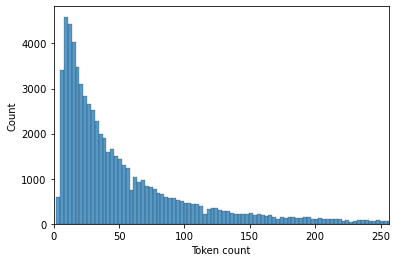

In [15]:
# Plot the distribution of sequence lengths to optimize the maximum sequence length used.  Large sequence lengths use a lot of GPU memory.

plot_dist = True

if plot_dist:

    token_lens = []

    for txt in comments:
      tokens = tokenizer.encode(txt, max_length=512, truncation=True)
      token_lens.append(len(tokens))

    sns.histplot(token_lens)
    plt.xlim([0, 256]);
    plt.xlabel('Token count');

In [16]:
# Limit the length of the sequence in tokens to control memory usage
MAX_LEN=100

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
print('Original: ', comments[0])
print('Token IDs:', input_ids[0])

Original:  ok go for it im only following your progress because you listed it for grading on wikiprojectaustralia so you should expect a thorough examination
Token IDs: tensor([  101,  7929,  2175,  2005,  2009, 10047,  2069,  2206,  2115,  5082,
         2138,  2017,  3205,  2009,  2005, 26886,  2006, 15536,  3211, 21572,
        20614, 20559, 21493,  2401,  2061,  2017,  2323,  5987,  1037, 16030,
         7749,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [17]:
# Examining tokenization
print("vocab size:",tokenizer.vocab_size)

vocab size: 30522


In [18]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

62,967 training samples
6,997 validation samples


In [19]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size
)

In [20]:
logging.set_verbosity_error() # set to warning to show warnings

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()
#model.cpu()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Defining loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
# Defining training epoch of BERT model
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    
  # Measure how long the training epoch takes.
  t0 = time.time()
    
  # Put the model into training mode
  model = model.train()

  losses = []
  correct_predictions = 0
  
  # For each batch of training data...
  for step, batch in enumerate(data_loader):
    
    # Progress update every few batches.
    if step % 200 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
              
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(data_loader), elapsed))
    
    # Unpack this training batch from our dataloader. 
    # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    targets = batch[2].type(torch.LongTensor).to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs[0], dim=1)
    loss = loss_fn(outputs[0], targets)

    correct_predictions += torch.sum(preds == targets)
    
    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
    losses.append(loss.item())

    # Perform a backward pass to calculate the gradients.
    loss.backward()
    
    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    # Update parameters and take a step using the computed gradient.
    optimizer.step()
    
    # Update the learning rate.
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
  model = model.eval()

  losses = []
  correct_predictions = 0

  # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training).
  with torch.no_grad():
    for batch in data_loader:
        
      # Unpack this validation batch from our dataloader. 
      # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      targets = batch[2].type(torch.LongTensor).to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs[0], dim=1)

      loss = loss_fn(outputs[0], targets)

      correct_predictions += torch.sum(preds == targets)
    
      # Accumulate the validation loss
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
%%time

history = defaultdict(list)
best_accuracy = 0

if pretrained:
    model.load_state_dict(torch.load('bert_male_notoxic_state.bin'))
    model = model.to(device)
else:
    # Performing training and validation for each epoch
    # Report loss and accuracy
    for epoch in range(epochs):

        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
        model,
        train_dataloader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        train_size
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
        model,
        validation_dataloader,
        loss_fn, 
        device, 
        val_size
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save the model if it has the best accuracy so far
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'bert_male_notoxic_state.bin')
            best_accuracy = val_acc

    # Plot the performance of the model over all epochs
    plt.figure(0)
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')

    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    
    plt.figure(1)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='validation loss')

    plt.title('Training history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1]);
    

CPU times: user 139 ms, sys: 84 ms, total: 223 ms
Wall time: 222 ms


Using male toxic test data without offensive words
Number of test sentences: 8,744

Predicting labels for 8,744 test sentences...
    DONE.
Total F1: 0.895
Accuracy: 0.81


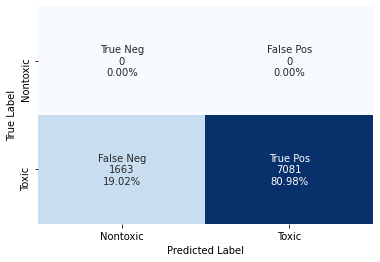

In [27]:
# Evaluating test set

# Initialising
accuracies = []

# Get previous test data if pretrained
if pretrained:
    with open("male_notoxic_test.data", 'rb') as file:
        df = pickle.load(file)
    file.close()
else:
    df = male_test_data
    with open("male_notoxic_test.data", 'wb') as file:
        pickle.dump(df,file)
    file.close()
    
df = df.sample(frac=1)
print('Using male toxic test data without offensive words')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Removing offensive words from comments
new_comments = []
for comment in comments:
    new_comment = clean_comment(comment)
    new_comments.append(new_comment)
comments = new_comments

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

Using male toxic test data with offensive words
Number of test sentences: 8,744

Predicting labels for 8,744 test sentences...
    DONE.
Total F1: 0.909
Accuracy: 0.83


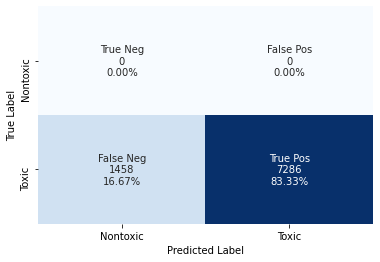

In [28]:
# Evaluating test set

# Initialising
accuracies = []
    
print('Using male toxic test data with offensive words')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

In [29]:
# Creating and evaluating female toxic test set

# Choose whether to use saved data
saved_test_set = True
    
if saved_test_set:
    with open("female_notoxic_test.data", 'rb') as file:
        df = pickle.load(file)
    file.close()
else:
    # Create balanced test data (between toxic and very toxic)
    female_toxic = toxic[toxic.female_binary == 1]
    female_very_toxic = very_toxic[very_toxic.female_binary == 1]
    test_size = min(test_size, female_toxic.shape[0],female_very_toxic.shape[0])
    female_toxic_test = female_toxic.sample(n=test_size)
    female_vtoxic_test = female_very_toxic.sample(n=test_size)
    df = pd.concat([female_toxic_test,female_vtoxic_test])
    
    # Removing punctuation and converting capital letters to lowercase
    df['comment'] = df['comment'].str.translate(str.maketrans('', '', string.punctuation))
    df['comment'] = df['comment'].str.lower()


Using female toxic test data without offensive words
Number of test sentences: 5,630

Predicting labels for 5,630 test sentences...
    DONE.
Total F1: 0.857
Accuracy: 0.75


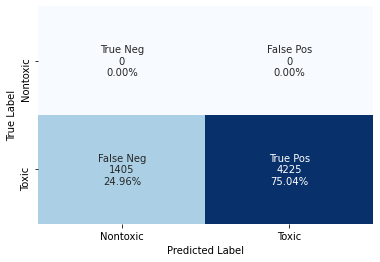

In [30]:
# Evaluating test set

# Initialising
accuracies = []

df = df.sample(frac=1)
print('Using female toxic test data without offensive words')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Removing offensive words from comments
new_comments = []
for comment in comments:
    new_comment = clean_comment(comment)
    new_comments.append(new_comment)
comments = new_comments

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")

Using female toxic test data with offensive words
Number of test sentences: 5,630

Predicting labels for 5,630 test sentences...
    DONE.
Total F1: 0.873
Accuracy: 0.77


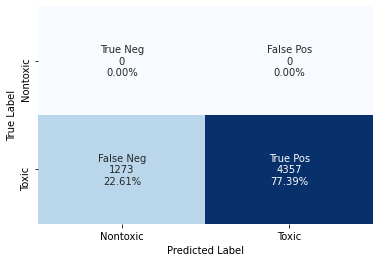

In [31]:
# Evaluating test set

# Initialising
accuracies = []

print('Using female toxic test data with offensive words')
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Extract necessary information
comments = df.comment.values
labels = df.toxicity.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for cmt in comments:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        cmt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
      
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
      
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')
  
# Combine the results across all batches. 
flat_pred = np.concatenate(predictions, axis=0)
# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_pred, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Return metrics
f1 = f1_score(flat_true_labels, flat_predictions)
print('Total F1: %.3f' % f1)
acc = accuracy_score(flat_true_labels,flat_predictions)
print('Accuracy: %.2f' % acc)
accuracies.append(acc)

# Print Confusion matrix
cf_matrix = confusion_matrix(flat_true_labels, flat_predictions)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
        zip(group_names,group_counts,group_percentages)]
matrix = pd.DataFrame(np.array([cf_matrix[0],cf_matrix[1]]), columns = ['Nontoxic','Toxic'], index=['Nontoxic','Toxic'])
matrix = matrix.rename_axis("True Label")
matrix = matrix.rename_axis("Predicted Label",axis="columns")
try:
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, fmt='',cbar = False, cmap='Blues')
    plt.show()
except ValueError:
    print("could not display")